# Darcy equation

In this tutorial we present how to solve a Darcy equation with [PyGeoN](https://github.com/compgeo-mox/pygeon) in themoving domain case (the upper boundary will move).  The unkwons are the velocity $u$, the elevation head $h$ and the height of the upper boundary $\eta$.

Let $\Omega=(0,1)\times(0,\eta)$ with boundary $\partial \Omega$ and outward unit normal ${\nu}$. Given 
$K$ the matrix permeability, we want to solve the following problem: find $(\bm{u}, h)$ such that
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
K^{-1} {\bm{u}} + \nabla h = {0}\\
S_s \frac{\partial{h}}{\partial t} + \nabla \cdot {u} = f
\end{array}
&\text{in } \Omega
\end{array}
\right.
$$

In order to solve the problem, we will perfom a change of coordinates to a reference domain $\hat{\Omega}=(0,1)^2$ through the (linear) trasnformation $R : \Omega \rightarrow \hat{\Omega}$ (and its inverse function $D : \hat{\Omega} \rightarrow \Omega$).
Recall that $\hat{\nabla}R=(\nabla D)^{-1}$.

Let $\hat{h}$ and $\hat{\bm{u}}$ be $h$ and $\bm{u}$ respectevely in the reference domain and let $\hat{K}$ be the transformed permeability matrix, defined as $\hat{K}=det(\hat{\nabla}D) (\hat{\nabla} D)^{-1} K (\hat{\nabla} D)^{-T}$.

The equation describing the motion of $\partial_{top}\Omega$ is:
$$

\phi \frac{\partial \eta}{\partial t} = \hat{u_3}

$$

The transformed equations in $\hat{\Omega}$ is:
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
\hat{K}(\hat{h})^{-1} {\hat{u}} + \hat{\nabla} \hat{h} = {0}\\
\hat{S}_s \frac{\partial{\hat{h}}}{\partial t} + \hat{\nabla} \cdot {\hat{\bm{u}}} = f
\end{array}
&\text{in } \hat{\Omega}
\end{array}
\right.
$$
with boundary conditions:
$$ \hat{h} = \eta \text{ on } \Gamma \qquad \hat{h} = \ell \text{ on } \Gamma_D \qquad \hat{\bm{\nu}} \cdot \hat{\bm{u}} = 0 \text{ on } \Gamma_N$$

The weak formulation will be:
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
\int_{\Omega}\hat{K}(\hat{h})^{-1} {\bm{\hat{u}}} \cdot \bm{v} \, d\Omega - \int_{\Omega} h \hat{\nabla} \cdot {\hat{\bm{v}}} \, d\Omega = - \int_{\Gamma_D} h \bm{v} \cdot \bm{\nu} \, d\Omega - \int_{\Gamma} \eta \bm{v} \cdot \bm{\nu} \, d\Omega\\
\int_{\Omega} \hat{S}_s \frac{\partial{\hat{h}}}{\partial t} v \, d\Omega + \int_{\Omega} \hat{\nabla} \cdot {\hat{\bm{u}}} v \, d\Omega = \int_{\Omega} fv \, d\Omega\\
\int_{\Gamma} \phi \frac{\partial \eta}{\partial t} v \, d\sigma = \int_{\Gamma} \hat{u_3} v \, d\sigma
\end{array}
\end{array}
\right.
$$

For the time discretization, we will employ a backward Euler scheme:

$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
\int_{\Omega}\hat{K}(\hat{h}^{n+1})^{-1} {\bm{\hat{u}}^{n+1}} \cdot \bm{v} \, d\Omega - \int_{\Omega} h^{n+1} \hat{\nabla} \cdot {\hat{\bm{v}}} \, d\Omega = - \int_{\Gamma_D} h^{n+1} \bm{v} \cdot \bm{\nu} \, d\Omega - \int_{\Gamma} \eta^{n+1} \bm{v} \cdot \bm{\nu} \, d\Omega\\
\int_{\Omega} \hat{S}_s^{n+1} \frac{\hat{h}^{n+1} - \hat{h}^{n}}{\Delta t} v \, d\Omega + \int_{\Omega} \hat{\nabla} \cdot {\hat{\bm{u}}^{n+1}} v \, d\Omega = \int_{\Omega} f^{n+1}v \, d\Omega\\
\int_{\Gamma} \phi \eta^{n+1} v \, d\sigma = \Delta t \int_{\Gamma} \hat{\bm{u}}^{n+1} \cdot \bm{\nu} v \, d\sigma + \int_{\Gamma} \phi \eta^{n} v \, d\sigma
\end{array}
\end{array}
\right.
$$

To deal with the non-linear term, we will employ a simple Picard scheme:

$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
\int_{\Omega}\hat{K}(\hat{h}^{n+1}_k)^{-1} {\bm{\hat{u}_{k+1}^{n+1}}} \cdot \bm{v} \, d\Omega - \int_{\Omega} h^{n+1}_{k+1} \hat{\nabla} \cdot {\hat{\bm{v}}} \, d\Omega + \int_{\Gamma} \eta^{n+1}_{k+1} \bm{v} \cdot \bm{\nu} \, d\Omega= - \int_{\Gamma_D} h^{n+1} \bm{v} \cdot \bm{\nu} \, d\Omega\\
\Delta t \int_{\Omega} \hat{\nabla} \cdot {\hat{\bm{u}}^{n+1}_{k+1}} v \, d\Omega + \int_{\Omega} \hat{S}_s \hat{h}^{n+1}_{k+1} v \, d\Omega = \int_{\Omega} \hat{S}_s \hat{h}^{n} v \, d\Omega + \Delta t \int_{\Omega} f^{n+1}v \, d\Omega\\
- \Delta t \int_{\Gamma} \hat{\bm{u}}^{n+1}_{k+1} \cdot \bm{\nu} v \, d\sigma + \int_{\Gamma} \phi \eta^{n+1}_{k+1} v \, d\sigma = \int_{\Gamma} \phi \eta^{n} v \, d\sigma
\end{array}
\end{array}
\right.
$$

The matrix formulation will be:

$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
M_u(\bm{h}^{n+1}_{k+1}) \bm{u}^{n+1}_{k+1} + B^T\bm{h}^{n+1}_{k+1} + B_{\Gamma} \bm{\eta}^{n+1}_{k+1}= \bm{BC}^{n+1}\\
- \Delta t B \hat{\bm{u}}^{n+1}_{k+1} + S_s M_{h} \bm{\hat{h}^{n+1}_{k+1}} = \Delta t \bm{F}^{n+1} + S_s M_{h} \bm{\hat{h}^{n}}\\
- \Delta t B_{\Gamma}^T \hat{\bm{u}}^{n+1}_{k+1} + \phi M_{\Gamma} \bm{\eta^{n+1}_{k+1}} = \phi M_{\Gamma} \bm{\eta^{n}}
\end{array}
\end{array}
\right.
$$

$$
\left(
\begin{array}{cc} 
M_u(\bm{h^{n+1}_k}) & B^T & B_{\Gamma}\\
-\Delta t B & S_s M_h & 0\\
-\Delta t B^T_{\Gamma} & 0 & \phi M_{\Gamma}
\end{array}
\right)
\left(
\begin{array}{c} 
\bm{u^{n+1}_{k+1}}\\ 
\bm{h^{n+1}_{k+1}}\\
\bm{\eta^{n+1}_{k+1}}
\end{array}
\right)
=\left(
\begin{array}{c} 
\bm{BC}^{n+1}\\ 
\Delta t \bm{F}^{n+1} + S_s M_h \bm{h}^n\\
\phi M_{\Gamma} \bm{\eta}^n
\end{array}
\right)
$$

We will start to test the method in the case $M_u(\bm{h_k}^{n+1})=\bm{I}$

In [1]:
import numpy as np
import scipy.sparse as sps
import os
import shutil

import porepy as pp
import pygeon as pg

In [2]:
output_directory = 'output'

We create now the grid, since we will use a Raviart-Thomas approximation for ${q}$ we are restricted to simplices. In this example we consider a 2-dimensional structured grid, but the presented code will work also in 1d and 3d. PyGeoN works with mixed-dimensional grids, so we need to convert the grid.

In [3]:
dt = 0.1
T = 10
S_s = 0.3
phi = 0.1
N = 5

In [4]:
# convert the grid into a mixed-dimensional grid
sd = pp.StructuredTriangleGrid([N, 2*N], [1, 2])

In [5]:
sd.compute_geometry()

/opt/conda/lib/python3.10/site-packages/porepy/viz/plot_grid.py:198: UserWarning: Attempting to set identical low and high zlims makes transformation singular; automatically expanding.
  ax.set_zlim3d(z)


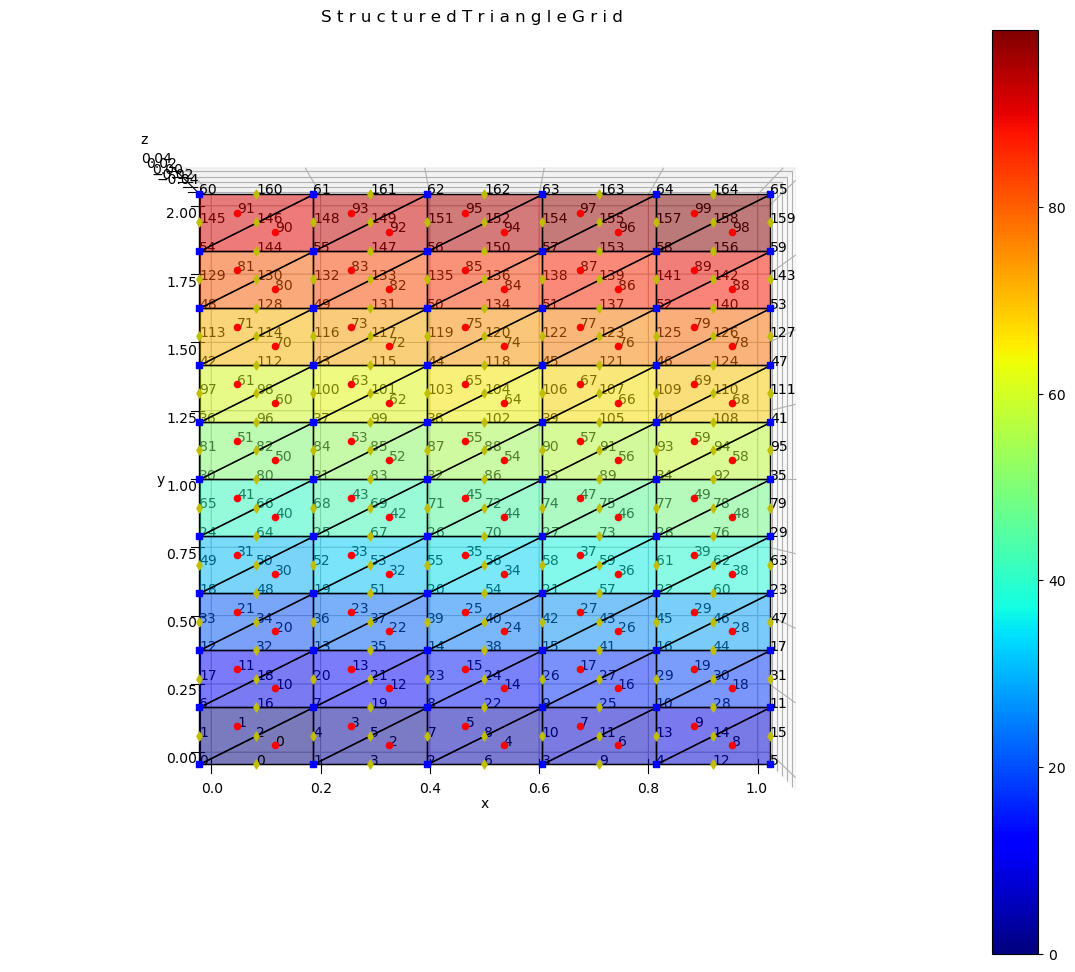

In [6]:
pp.plot_grid(
    sd,
    cell_value=np.arange(sd.num_cells),
    info="cfn",
    alpha=0.5,
    figsize=(15, 12),
)

In [7]:
grid_status = pp.partition.partition(sd, 2)

In [8]:
darcy_grid, darcy_face_map, darcy_node_map = pp.partition.extract_subgrid( sd, grid_status == 0 )
richard_grid, richards_face_map, richards_node_map = pp.partition.extract_subgrid(sd, grid_status == 1)

In [9]:
faces = np.zeros(shape=(sd.num_faces,), dtype=bool)
faces[ np.intersect1d(darcy_face_map, richards_face_map) ] = True

In [10]:
boundary_grid, boundary_face_map, boundary_node_map = pp.partition.extract_subgrid(sd, faces, faces=True)

In [11]:
mdg = pp.meshing.subdomains_to_mdg([[darcy_grid, richard_grid]])

With the following code we set the data, in particular the permeability tensor and the boundary conditions. Since we need to identify each side of $\partial \Omega$ we need few steps.

In [12]:
gamma = pg.Lagrange1('flow')
gamma.assemble_mass_matrix( boundary_grid ).todense()

matrix([[0.06666667, 0.03333333, 0.        , 0.        , 0.        ,
         0.        ],
        [0.03333333, 0.13333333, 0.03333333, 0.        , 0.        ,
         0.        ],
        [0.        , 0.03333333, 0.13333333, 0.03333333, 0.        ,
         0.        ],
        [0.        , 0.        , 0.03333333, 0.13333333, 0.03333333,
         0.        ],
        [0.        , 0.        , 0.        , 0.03333333, 0.13333333,
         0.03333333],
        [0.        , 0.        , 0.        , 0.        , 0.03333333,
         0.06666667]])

In [13]:
key = "flow"
bc_val = []
bc_ess = []
initial_pressure = []

velocity_discretization_field = pg.RT0(key)
head_discretization_field = pg.PwConstants(key)

sd, data = mdg.subdomains(return_data=True)[0]

# permeability tensor
perm = pp.SecondOrderTensor(np.ones(sd.num_cells))
parameters = {
    "second_order_tensor": perm,
}

pp.initialize_data(sd, data, key, parameters)
    
# with the following steps we identify the portions of the boundary
# to impose the boundary conditions
left_right = np.logical_or(sd.face_centers[0, :] == 0,  sd.face_centers[0, :] == 1)

bottom = sd.face_centers[1, :] == 0
top    = sd.face_centers[1, :] == 1

ess_p_dofs = np.zeros(head_discretization_field.ndof(sd), dtype=bool)

def h_bc(x): return 1
def initial_h_func(x): return 1-x[1]

bc_val.append(-velocity_discretization_field.assemble_nat_bc(sd, h_bc, bottom))

bc_ess.append(np.hstack((left_right, ess_p_dofs, np.zeros(N+1, dtype=bool))))

In [14]:
def assemble_B_gamma():
    data = []
    row = []
    col = []

    faces_center_pos = sd.face_centers[0,:]
    index_up_face = np.where(sd.face_centers[1, :] == 1)[0]

    for i in range(N):
        col.append(index_up_face[i])
        row.append(i)
        data.append( np.abs(faces_center_pos[i] - faces_center_pos[i+1]) / 2 )
        
        col.append(index_up_face[i])
        row.append(i+1)
        data.append( np.abs(faces_center_pos[i] - faces_center_pos[i+1]) / 2 )
    
    return sps.coo_matrix( (data, (row, col)) )

In [18]:
B_gamma = assemble_B_gamma()
B_gamma.todense()

matrix([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
         0.05, 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
         0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 

$$
\left(
\begin{array}{cc} 
M_u(\bm{h^{n+1}_k}) & B^T & B_{\Gamma}\\
-\Delta t B & S_s M_h & 0\\
-\Delta t B^T_{\Gamma} & 0 & \phi M_{\Gamma}
\end{array}
\right)
\left(
\begin{array}{c} 
\bm{u^{n+1}_{k+1}}\\ 
\bm{h^{n+1}_{k+1}}\\
\bm{\eta^{n+1}_{k+1}}
\end{array}
\right)
=\left(
\begin{array}{c} 
\bm{BC}^{n+1}\\ 
\Delta t \bm{F}^{n+1} + S_s M_h \bm{h}^n\\
\phi M_{\Gamma} \bm{\eta}^n
\end{array}
\right)
$$

In [18]:
# construct the local matrices
mass = pg.face_mass(mdg)
div = - pg.cell_mass(mdg, head_discretization_field) @ pg.div(mdg)

# get the degrees of freedom for each variable
dof_p, dof_q = div.shape
dof_eta = B_gamma.shape[0]

mass.shape, div.shape, B_gamma.shape

((170, 170), (100, 170), (6, 85))

In [19]:
# assemble the right-hand side
fixex_rhs = np.zeros(dof_p + dof_q + dof_eta)
fixex_rhs[:dof_q] += np.hstack(bc_val)

ValueError: operands could not be broadcast together with shapes (170,) (85,) (170,) 

In [ ]:
# assemble the saddle point problem
spp = sps.bmat([[    mass,                                                         div.T,          B_gamma.T], 
                [    -div, S_s / dt * head_discretization_field.assemble_mass_matrix(sd),               None],
                [-B_gamma,                                                          None, phi / dt * M_gamma]], format="csc")

In [ ]:
def save_step(sol, proj_q, proj_psi, saver, i):
    ins = list()

    ins.append((sd, "cell_q", ( proj_q @ sol[-1][:dof_q] ).reshape((3, -1), order="F")))
    ins.append((sd, "cell_p", proj_psi @ sol[-1][dof_q:(dof_q+dof_p)]))
    print( sol[-1][-dof_eta:] )
    
    saver.write_vtu(ins, time_step=i)

In [ ]:
if os.path.exists(output_directory):
    shutil.rmtree(output_directory)

In [ ]:
sol = [np.zeros(dof_p + dof_q + dof_eta)]
sol[-1][dof_q:(dof_q+dof_p)] = head_discretization_field.interpolate(sd, initial_h_func)
sol[-1][-dof_eta:] = np.ones_like(sol[-1][-dof_eta:])

proj_q = velocity_discretization_field.eval_at_cell_centers(sd)
proj_psi = head_discretization_field.eval_at_cell_centers(sd)

saver = pp.Exporter(mdg, 'sol', folder_name=output_directory)
save_step(sol, proj_q, proj_psi, saver, 0)

[1. 1. 1. 1. 1. 1.]


In [ ]:
for i in range(1, int(T/dt)+1):
    rhs = fixex_rhs.copy()
    rhs[dof_q:(dof_q+dof_p)] += S_s / dt * head_discretization_field.assemble_mass_matrix(sd) @ sol[-1][dof_q:(dof_q+dof_p)]
    rhs[-dof_eta:] += phi / dt * M_gamma @ sol[-1][-dof_eta:]
    
    ls = pg.LinearSystem(spp, rhs)
    ls.flag_ess_bc(np.hstack(bc_ess), np.zeros(dof_q + dof_p + dof_eta))
    sol.append( ls.solve() )

    save_step(sol, proj_q, proj_psi, saver, i)

    print('Time ' + str(dt * i) )

saver.write_pvd([t * dt for t in range(int(T/dt)+1)])

[0.763295   0.80359696 0.72148976 0.72150015 0.80369302 0.76345592]
Time 0.1
[0.54784718 0.6148363  0.48444954 0.48445889 0.61489478 0.54793609]
Time 0.2
[0.33999455 0.42135253 0.26971739 0.26972309 0.421381   0.34003442]
Time 0.30000000000000004
[0.13809515 0.22255788 0.07290736 0.07290945 0.22256172 0.13809656]
Time 0.4
[-0.05801891  0.01924008 -0.10842141 -0.10842266  0.01922197 -0.05805139]
Time 0.5
[-0.24827896 -0.18766347 -0.27613179 -0.27613614 -0.18770175 -0.24834246]
Time 0.6000000000000001
[-0.43260832 -0.39728308 -0.4317902  -0.43179744 -0.39734002 -0.43270046]
Time 0.7000000000000001
[-0.61096542 -0.60885144 -0.57675037 -0.57676032 -0.60892567 -0.61108403]
Time 0.8
[-0.78334746 -0.82170031 -0.71219138 -0.71220386 -0.82179053 -0.78349048]
Time 0.9
[-0.94978606 -1.03525009 -0.83914282 -0.83915765 -1.03535508 -0.94995153]
Time 1.0
[-1.11034167 -1.24899889 -0.95850475 -0.95852179 -1.24911749 -1.11052776]
Time 1.1
[-1.26509851 -1.46251271 -1.07106472 -1.07108382 -1.46264384 -1.2